In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [2]:
%%time
path = '/datb/16011015/ExoGAN_data/selection//'
data = np.load(path+'first_chunks_25_percent.npy')
np.random.shuffle(data) # shuffle the array, make sure the distribution is random (by index atleast)

CPU times: user 41.7 s, sys: 8.94 s, total: 50.6 s
Wall time: 51.1 s


In [3]:
"""
data contains 10k dictionaries of 50 chunks
"""
data.shape

(50, 25000)

In [4]:
data = data.flatten()

#data = data[:100000]

data.shape

(1250000,)

# Plot spectra

In [ ]:
wavelengths = ke.load_wavelengths()

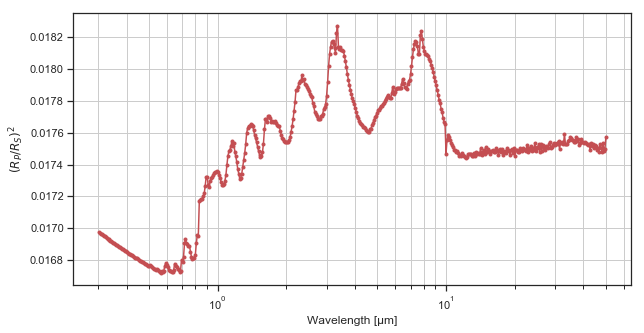

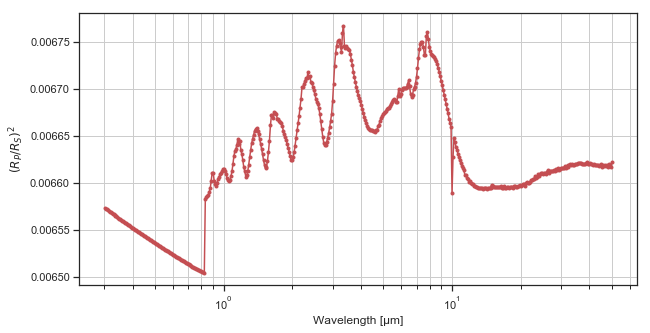

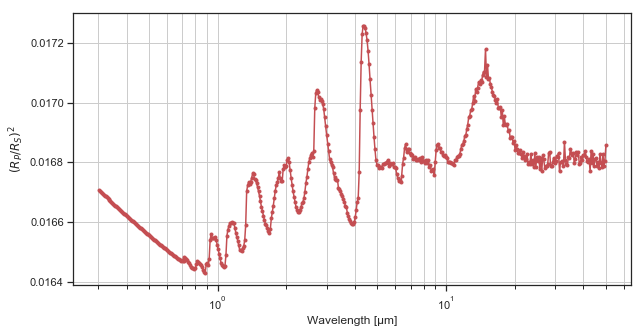

In [ ]:
n = 4 # number of spectra to plot

indices = np.random.randint(0, len(data), size=n)

spectra = [data[i]['data']['spectrum'] for i in indices] # load the n randomly selected spectra into an array

df = pd.DataFrame(spectra).T # take the transpose so axis 0 are the R/R values
df['x'] = wavelengths


for i in range(n):
    ke.plot_spectrum(df.x, df[i])

(0.015, 0.03)

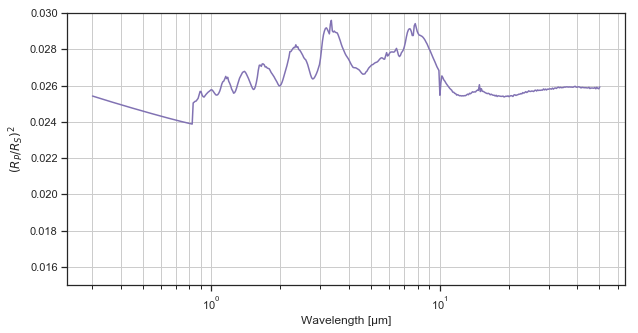

In [ ]:
"""
Do the same thing but put it in one figure (with more spectra)
"""

# Grab a new sample

n = 5 # number of spectra to plot

indices = np.random.randint(0, len(data), size=n)

spectra = [data[i]['data']['spectrum'] for i in indices] # load the n randomly selected spectra into an array

df = pd.DataFrame(spectra).T # take the transpose so axis 0 are the R/R values
df['x'] = wavelengths

i=0
y = df[i].values.reshape(-1,1)
y.shape

# Plot the sample

plt.figure(figsize=(10,5))

for i in range(n):
    plt.plot(df.x, df[i])
    
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'$(R_P / R_S)^2$')

plt.grid(True, which="both", ls='-')
    

plt.xscale('log')

plt.ylim((0.015,0.03))

(0.3, 16)

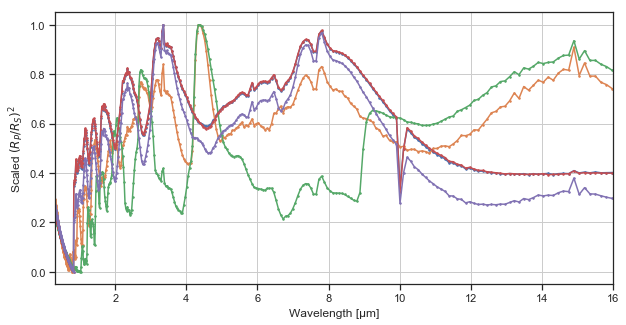

In [ ]:
plt.figure(figsize=(10,5))

for i in range(n):
    y = df[i].values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1)).fit(y)
    y = scaler.transform(y)

    plt.plot(df.x, y, '.-', ms=3)
    
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'Scaled $(R_P / R_S)^2$')

plt.grid(True, which="both", ls='-')


#plt.xscale('log')

plt.xlim((0.3,16))

# Wavelengths and indices

In [ ]:
df[['x']].to_csv('wavelengths_and_indices.csv')

# Look at the params
Using multiprocessing to create the dfs cuts the creation time of `params` down from 10 minutes to 4 minutes.

In [ ]:
from multiprocessing import Pool

input_data = [(i) for i in range(len(data))] # input to f must be a tuple

def f(t):
    i = t
    param = pd.DataFrame(data[i]['param'], index=[0])
    return param

In [ ]:
%%time
pool = Pool() # server has 2x 12 cores -> Pool(processes=24)
params = pool.map(f, input_data, chunksize=1)

CPU times: user 3min 25s, sys: 33.1 s, total: 3min 58s
Wall time: 3min 51s


In [ ]:
%%time
pool.close()
pool.join()
pool.terminate() # not nice but meh, pool.join() gets stuck... https://stackoverflow.com/questions/15314189/python-multiprocessing-pool-hangs-at-join

CPU times: user 3.09 ms, sys: 524 µs, total: 3.62 ms
Wall time: 2.4 s


In [ ]:
%%time
params = pd.concat(params)
params.head()

CPU times: user 1min 40s, sys: 3.55 s, total: 1min 44s
Wall time: 1min 44s


In [ ]:
params.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250000 entries, 0 to 0
Data columns (total 7 columns):
planet_mass            1250000 non-null float64
temperature_profile    1250000 non-null float64
ch4_mixratio           1250000 non-null float64
planet_radius          1250000 non-null float64
h2o_mixratio           1250000 non-null float64
co2_mixratio           1250000 non-null float64
co_mixratio            1250000 non-null float64
dtypes: float64(7)
memory usage: 76.3 MB


In [ ]:
params.describe()

planet_mass  temperature_profile  ch4_mixratio  planet_radius  \
count  1.250000e+06         1.250000e+06  1.250000e+06   1.250000e+06   
mean   2.656956e+27         1.500297e+03  1.201539e-02   8.039690e+07   
std    7.268432e+26         3.188851e+02  2.975760e-02   1.561777e+07   
min    1.518400e+27         1.000000e+03  1.000000e-08   5.592880e+07   
25%    2.024533e+27         1.222222e+03  3.593814e-07   6.680384e+07   
50%    2.530667e+27         1.555556e+03  7.742637e-05   8.311641e+07   
75%    3.289867e+27         1.777778e+03  2.782559e-03   9.399146e+07   
max    3.796000e+27         2.000000e+03  1.000000e-01   1.048665e+08   

       h2o_mixratio  co2_mixratio   co_mixratio  
count  1.250000e+06  1.250000e+06  1.250000e+06  
mean   1.200086e-02  1.202782e-02  1.195297e-02  
std    2.974033e-02  2.977589e-02  2.967776e-02  
min    1.000000e-08  1.000000e-08  1.000000e-08  
25%    3.593814e-07  3.593814e-07  3.593814e-07  
50%    7.742637e-05  1.291550e-05  7.742637e-05  
75%    2.782559e-03  2.782559e-03  2.782559e-03  
max    1.000000e-01  1.000000e-01  1.000000e-01

In [ ]:
# Transform mixratios to logarithmic

for param in params:
    if 'mixratio' in param:
        params[param] = np.log10(params[param])

params.describe()

planet_mass  temperature_profile  ch4_mixratio  planet_radius  \
count  1.250000e+06         1.250000e+06  1.250000e+06   1.250000e+06   
mean   2.656956e+27         1.500297e+03 -4.498933e+00   8.039690e+07   
std    7.268432e+26         3.188851e+02  2.234916e+00   1.561777e+07   
min    1.518400e+27         1.000000e+03 -8.000000e+00   5.592880e+07   
25%    2.024533e+27         1.222222e+03 -6.444444e+00   6.680384e+07   
50%    2.530667e+27         1.555556e+03 -4.111111e+00   8.311641e+07   
75%    3.289867e+27         1.777778e+03 -2.555556e+00   9.399146e+07   
max    3.796000e+27         2.000000e+03 -1.000000e+00   1.048665e+08   

       h2o_mixratio  co2_mixratio   co_mixratio  
count  1.250000e+06  1.250000e+06  1.250000e+06  
mean  -4.499587e+00 -4.500441e+00 -4.501439e+00  
std    2.233895e+00  2.234241e+00  2.233428e+00  
min   -8.000000e+00 -8.000000e+00 -8.000000e+00  
25%   -6.444444e+00 -6.444444e+00 -6.444444e+00  
50%   -4.111111e+00 -4.888889e+00 -4.111111e+00  
75%   -2.555556e+00 -2.555556e+00 -2.555556e+00  
max   -1.000000e+00 -1.000000e+00 -1.000000e+00

In [ ]:
plt.figure(figsize=(20,10))

for i, param in enumerate(params.columns):
    plt.subplot(3,3,i+1)
    plt.grid(True, which="both", ls='-')
    
    if 'mixratio' in param:
        plt.title('%s (dex)' % param)
        plt.hist(params[param], bins=10)
        #plt.xscale('log')
    else:
        plt.title(param)
        plt.hist(params[param], bins=10)

plt.tight_layout()

In [ ]:
params.describe()